In [2]:
import zipfile
import os

# This assumes you uploaded a file named "AugmentedAlzheimerDataset.zip"
# If your mac named it "Archive.zip", change the name below.
zip_path = "AugmentedAlzheimerDataset.zip"

print("Unzipping the dataset... this might take a minute...")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./dataset") # We extract it to a folder named 'dataset'

print("Done! Checking file counts...")

# Let's verify we have the right folders
base_path = "./dataset/AugmentedAlzheimerDataset"
categories = os.listdir(base_path)
print(f"Found categories: {categories}")

# Count images to make sure it matches the PDF claims
total_images = 0
for category in categories:
    if not category.startswith('.'): # Ignore hidden mac files like .DS_Store
        path = os.path.join(base_path, category)
        count = len(os.listdir(path))
        print(f" - {category}: {count} images")
        total_images += count

print(f"Total images found: {total_images}")

Unzipping the dataset... this might take a minute...
Done! Checking file counts...
Found categories: ['NonDemented', 'ModerateDemented', 'MildDemented', 'VeryMildDemented']
 - NonDemented: 9600 images
 - ModerateDemented: 6464 images
 - MildDemented: 8960 images
 - VeryMildDemented: 8960 images
Total images found: 33984


In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"We are using: {device}")



# Tensor
x = torch.rand(3,3).to(device)
print("\nHere is a 3x3 Tensor living on the GPU:")
print(x)

We are using: cuda

Here is a 3x3 Tensor living on the GPU:
tensor([[0.7992, 0.9077, 0.9001],
        [0.2471, 0.0270, 0.3519],
        [0.8857, 0.3207, 0.1258]], device='cuda:0')


In [4]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_path = "./dataset/AugmentedAlzheimerDataset"

image_paths = []
labels = []


for category in os.listdir(base_path):
  category_path = os.path.join(base_path, category)

  # check if folder
  if os.path.isdir(category_path):
    for filename in os.listdir(category_path):
      # we only want image files
      image_paths.append(os.path.join(category_path, filename))
      labels.append(category)



# creating the dataframe
df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})



# label encoder
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])


# split into train and test
train_df, test_df = train_test_split(df, test_size = 0.2, stratify=df["label_encoded"], random_state = 42) # here stratify indiciates we get an equal mix of alzheimers cases in both cases


print(f"Total Images: {len(df)}")
print(f"Training on: {len(train_df)} images")
print(f"Testing on: {len(test_df)} images")

# Show the first few rows so we can see what the data looks like
print("\nExample Data:")
print(train_df.head())

Total Images: 33984
Training on: 27187 images
Testing on: 6797 images

Example Data:
                                              image_path             label  \
431    ./dataset/AugmentedAlzheimerDataset/NonDemente...       NonDemented   
4753   ./dataset/AugmentedAlzheimerDataset/NonDemente...       NonDemented   
9725   ./dataset/AugmentedAlzheimerDataset/ModerateDe...  ModerateDemented   
10854  ./dataset/AugmentedAlzheimerDataset/ModerateDe...  ModerateDemented   
27874  ./dataset/AugmentedAlzheimerDataset/VeryMildDe...  VeryMildDemented   

       label_encoded  
431                2  
4753               2  
9725               1  
10854              1  
27874              3  


In [14]:
# Data loader

In [15]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
import torch

# Define the transformations (copied from 0IKx6P4AED4z for self-containment)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# For testing, we DON'T flip or rotate. We want to test on the "real" image.
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset class (corrected __getitem__ method)
class MRIDataset(Dataset):
  def __init__(self, df, transform = None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx): # CORRECTED: changed __get_item to __getitem__
    # The model asks: "Give me the image at row number 'idx'"
    try:
      row = self.df.iloc[idx]
      img_path = row["image_path"]
      label = row["label_encoded"]
      # Open the image file
      image = Image.open(img_path).convert("RGB")
      # Apply transformations
      if self.transform:
        image = self.transform(image)
      return image, torch.tensor(label).long()
    except Exception as e:
      print(f"Error loading image at index {idx}: {e}")
      return None

train_ds = MRIDataset(train_df, transform=train_transforms)
test_ds = MRIDataset(test_df, transform=test_transforms)

# 4. Re-create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print("Class re-defined and loaders ready.")

# 5. Test it immediately
images, labels = next(iter(train_loader))
print(f"Success! Batch shape: {images.shape}")

Class re-defined and loaders ready.
Success! Batch shape: torch.Size([32, 3, 224, 224])


In [17]:
# BRain(CNN)
import torch.nn as nn
from torchvision import models


class HybridModel(nn.Module):
  def __init__(self, num_classes = 4):
    super().__init__()

    # Using MobileNetV2, pretrained on ImageNet
    self.cnn = models.mobilenet_v2(weights="IMAGENET1K_V1").features


    # Just train transformer brain
    for param in self.cnn.parameters():
      param.requires_grad = True


    # The BRAIN(Transformer)
    encoder_layer = nn.TransformerEncoderLayer(
        d_model = 1280,
        nhead = 8, # model looks at 8 differentt perspecives at once
        dim_feedforward = 2048,
        dropout = 0.1,
        batch_first = True # ensures input format is [Batch, Sequence, Features]
    )
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = 2)


    # Mouth (Classifer)
    self.fc = nn.Linear(1280, num_classes) # turn 1280 features into 4 probabilites

  def forward(self, x):
    # Look at image
    # Input [Batch, 3, 224, 224]
    x = self.cnn(x)
    # Output: [Batch, 1280, 7, 7]


    # Squash the image
    # We take the average of the 7x7 grid to get one single summary vector per image.
    x = x.mean([-1, -2])
    # Output: [Batch, 1280]


    # Prepare for transformer
    x = x.unsqueeze(1)
    # Output: [Batch, 1, 1280]

    # Think
    x = self.transformer(x)


    # Remove the sequence dimension
    x = x.squeeze(1)
    # Output: [Batch, 1280]


    # Decide (Linear layer)
    x = self.fc(x)
    # Output: [Batch, 4]
    return x

# Instantiate the model and move it to the GPU
model = HybridModel(num_classes=4).to(device)

print("Hybrid Model Created Successfull!")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 87.6MB/s]


Hybrid Model Created Successfull!


In [18]:
# Create a fake input tensor (Batch=32, RGB=3, Size=224x224)
dummy_input = torch.randn(32, 3, 224, 224).to(device)

# Pass it through the model
output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

# Expected Output shape: [32, 4]
# (32 images, 4 scores each)

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 4])


In [19]:
# Training Loop
import torch.optim as optim
from tqdm.notebook import tqdm



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

# training function
def train_one_epoch(epoch_index, train_loader):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0

  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_index+1} Training")


  for images, labels in progress_bar:
    images, labels = images.to(device), labels.to(device)

    # zero the gradients
    optimizer.zero_grad()

    # Forward pass, make ur first guess
    outputs = model(images)

    # Calc loss
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # track stats for progress bar
    running_loss += loss.item()
    _, predicted = torch.max(outputs, 1) # get the class with high prob
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    # update the progress bar text
    current_acc = 100 * correct_predictions / total_samples
    progress_bar.set_postfix({'Loss': loss.item(), 'Acc': f"{current_acc:.2f}%"})

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100 * correct_predictions / total_samples
  return epoch_loss, epoch_acc



# validation function (praccitse function)
def validate(test_loader):
  model.eval()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0


  with torch.no_grad(): # Dont calc gradients to save time
    for images, labels in tqdm(test_loader, desc="Validating"):
      images, labels  = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1) # get the class with high prob
      correct_predictions += (predicted == labels).sum().item()
      total_samples += labels.size(0)

  epoch_loss = running_loss / len(test_loader)
  epoch_acc = 100 * correct_predictions / total_samples
  return epoch_loss, epoch_acc

print("Training functions defined.")



Training functions defined.


In [21]:
# START TRAINING
EPOCHS = 5
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
  print(f"\n--- EPOCH {epoch+1}/{EPOCHS} ---")


  # Train
  train_loss, train_acc = train_one_epoch(epoch, train_loader)

  # Validate
  val_loss, val_acc = validate(test_loader)

  # Store the history
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)

  print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
  print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")


print("\nTRAINING COMPLETE!")



--- EPOCH 1/5 ---


Epoch 1 Training:   0%|          | 0/850 [00:00<?, ?it/s]

Validating:   0%|          | 0/213 [00:00<?, ?it/s]

Train Loss: 0.6528 | Train Acc: 70.86%
Val Loss:   0.4135 | Val Acc:   81.82%

--- EPOCH 2/5 ---


Epoch 2 Training:   0%|          | 0/850 [00:00<?, ?it/s]

Validating:   0%|          | 0/213 [00:00<?, ?it/s]

Train Loss: 0.3214 | Train Acc: 87.02%
Val Loss:   0.1696 | Val Acc:   93.51%

--- EPOCH 3/5 ---


Epoch 3 Training:   0%|          | 0/850 [00:00<?, ?it/s]

Validating:   0%|          | 0/213 [00:00<?, ?it/s]

Train Loss: 0.1862 | Train Acc: 92.91%
Val Loss:   0.1013 | Val Acc:   96.15%

--- EPOCH 4/5 ---


Epoch 4 Training:   0%|          | 0/850 [00:00<?, ?it/s]

Validating:   0%|          | 0/213 [00:00<?, ?it/s]

Train Loss: 0.1231 | Train Acc: 95.53%
Val Loss:   0.0716 | Val Acc:   97.43%

--- EPOCH 5/5 ---


Epoch 5 Training:   0%|          | 0/850 [00:00<?, ?it/s]

Validating:   0%|          | 0/213 [00:00<?, ?it/s]

Train Loss: 0.0949 | Train Acc: 96.79%
Val Loss:   0.0563 | Val Acc:   98.18%

TRAINING COMPLETE!


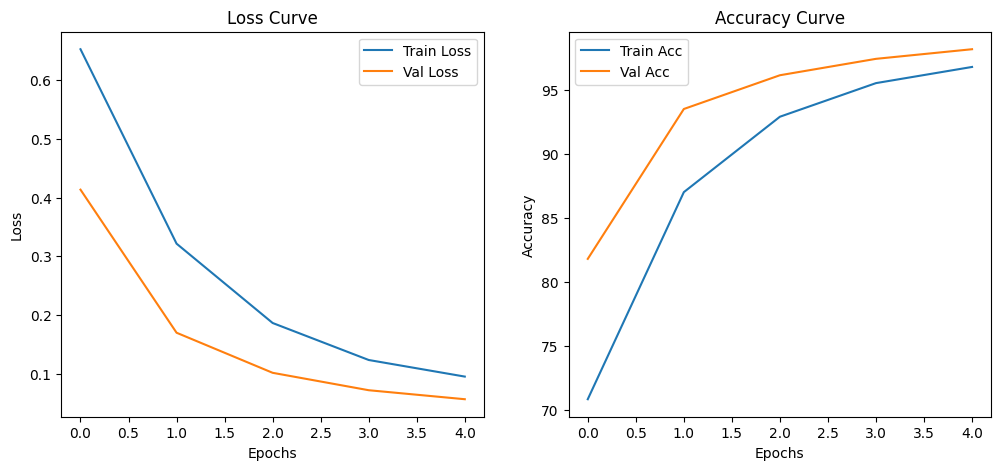

Generating Predictions:   0%|          | 0/213 [00:00<?, ?it/s]

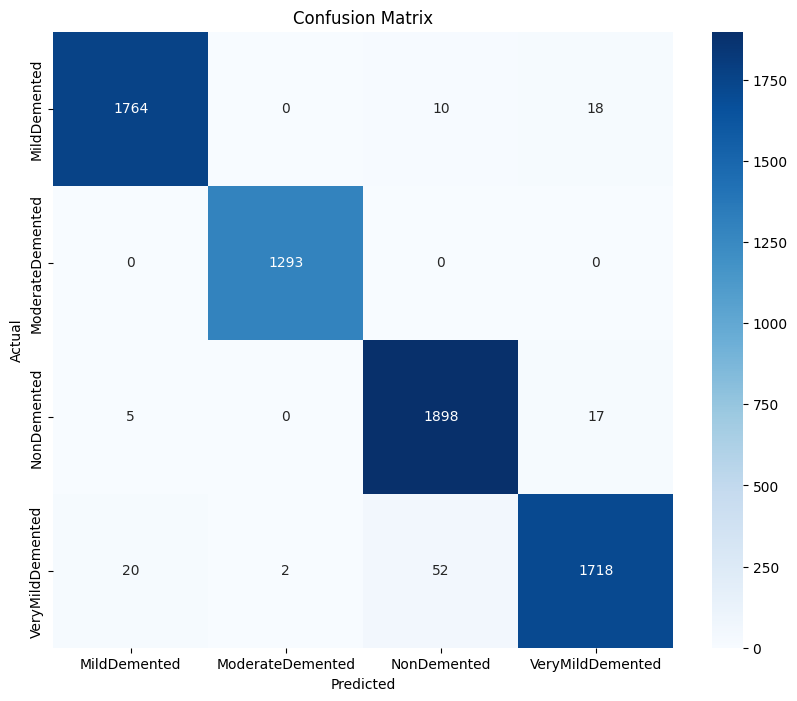


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.99      0.98      0.99      1792
ModerateDemented       1.00      1.00      1.00      1293
     NonDemented       0.97      0.99      0.98      1920
VeryMildDemented       0.98      0.96      0.97      1792

        accuracy                           0.98      6797
       macro avg       0.98      0.98      0.98      6797
    weighted avg       0.98      0.98      0.98      6797



In [23]:
# Visulisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np



plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
  for images, labels in tqdm(test_loader, desc="Generating Predictions"):
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = le.classes_ # names we have saved earlier

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 4. Print the Detailed Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))




Running diagnostic on a random patient...


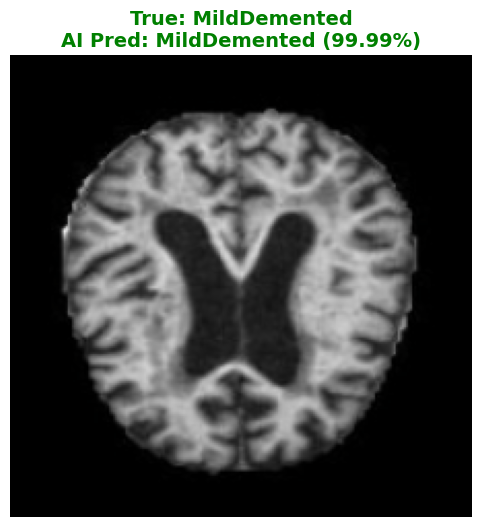

In [24]:
# predictor function
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, dataset, index=None):
  """
  pick an image, show it, and ask the model what it is.
  """
  model.eval() # set to eval mode

  if index is None:
    index = np.random.randint(0, len(dataset))

    # get image and label from dataset
    # we are using the dataset object beacusing it handles and resises/transfomers, etc.
    image_tensor, true_label_index = dataset[index]

    # Prepare image for model (adding the batch dimension)
    # The model expects [Batch, 3, 224, 224,] but we have [3, 224, 224]
    input_tensor = image_tensor.unsqueeze(0).to(device)


    # Make the prediction
    with torch.no_grad():
      output = model(input_tensor)

      # Calc probabilites
      probs = F.softmax(output, dim=1)
      confidence, predicted_class_index = torch.max(probs, 1)


    # Decode the answer
    predicted_label = le.classes_[predicted_class_index.item()]
    true_label = le.classes_[true_label_index.item()]
    conf_score = confidence.item() * 100



    # visualization
    inv_normalize = transforms.Normalize(
        mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std = [1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(image_tensor)


    # Rearrage the dimensions for matplotlib (C,H,W) -> (H,W,C)
    img_display = img_display.permute(1,2,0).numpy()

    # Clip values to be between 0 and 1 just in case
    img_display = np.clip(img_display, 0,1 )

    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.axis('off')

    # Color code, green if correct, red if wrong
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {true_label}\nAI Pred: {predicted_label} ({conf_score:.2f}%)", color=color, fontsize=14, fontweight='bold')
    plt.show()

# Run this multiple times to see different patients!
print("Running diagnostic on a random patient...")
predict_single_image(model, test_ds)

Running diagnostic on a random patient...


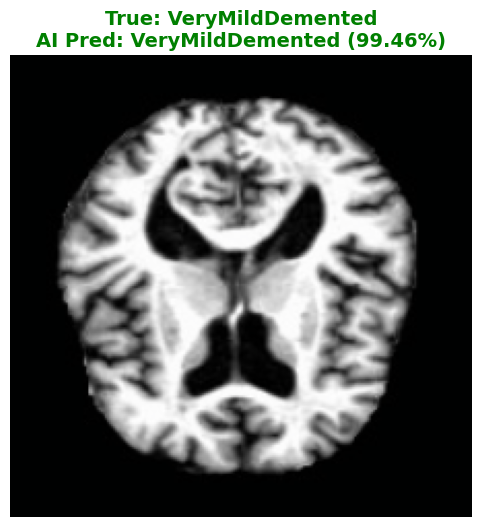

In [25]:
# predictor function
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, dataset, index=None):
  """
  pick an image, show it, and ask the model what it is.
  """
  model.eval() # set to eval mode

  if index is None:
    index = np.random.randint(0, len(dataset))

    # get image and label from dataset
    # we are using the dataset object beacusing it handles and resises/transfomers, etc.
    image_tensor, true_label_index = dataset[index]

    # Prepare image for model (adding the batch dimension)
    # The model expects [Batch, 3, 224, 224,] but we have [3, 224, 224]
    input_tensor = image_tensor.unsqueeze(0).to(device)


    # Make the prediction
    with torch.no_grad():
      output = model(input_tensor)

      # Calc probabilites
      probs = F.softmax(output, dim=1)
      confidence, predicted_class_index = torch.max(probs, 1)


    # Decode the answer
    predicted_label = le.classes_[predicted_class_index.item()]
    true_label = le.classes_[true_label_index.item()]
    conf_score = confidence.item() * 100



    # visualization
    inv_normalize = transforms.Normalize(
        mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std = [1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(image_tensor)


    # Rearrage the dimensions for matplotlib (C,H,W) -> (H,W,C)
    img_display = img_display.permute(1,2,0).numpy()

    # Clip values to be between 0 and 1 just in case
    img_display = np.clip(img_display, 0,1 )

    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.axis('off')

    # Color code, green if correct, red if wrong
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {true_label}\nAI Pred: {predicted_label} ({conf_score:.2f}%)", color=color, fontsize=14, fontweight='bold')
    plt.show()

# Run this multiple times to see different patients!
print("Running diagnostic on a random patient...")
predict_single_image(model, test_ds)

Running diagnostic on a random patient...


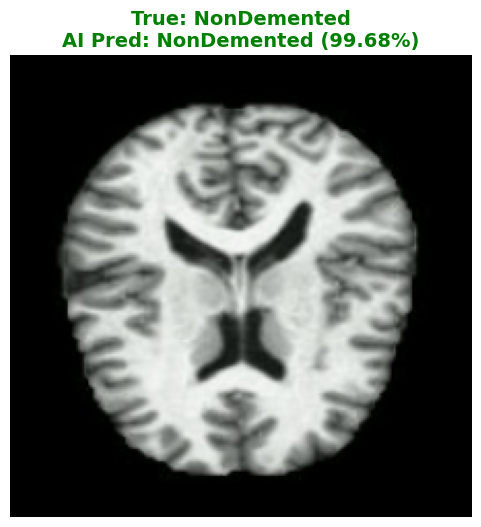

In [26]:
# predictor function
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, dataset, index=None):
  """
  pick an image, show it, and ask the model what it is.
  """
  model.eval() # set to eval mode

  if index is None:
    index = np.random.randint(0, len(dataset))

    # get image and label from dataset
    # we are using the dataset object beacusing it handles and resises/transfomers, etc.
    image_tensor, true_label_index = dataset[index]

    # Prepare image for model (adding the batch dimension)
    # The model expects [Batch, 3, 224, 224,] but we have [3, 224, 224]
    input_tensor = image_tensor.unsqueeze(0).to(device)


    # Make the prediction
    with torch.no_grad():
      output = model(input_tensor)

      # Calc probabilites
      probs = F.softmax(output, dim=1)
      confidence, predicted_class_index = torch.max(probs, 1)


    # Decode the answer
    predicted_label = le.classes_[predicted_class_index.item()]
    true_label = le.classes_[true_label_index.item()]
    conf_score = confidence.item() * 100



    # visualization
    inv_normalize = transforms.Normalize(
        mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std = [1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(image_tensor)


    # Rearrage the dimensions for matplotlib (C,H,W) -> (H,W,C)
    img_display = img_display.permute(1,2,0).numpy()

    # Clip values to be between 0 and 1 just in case
    img_display = np.clip(img_display, 0,1 )

    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.axis('off')

    # Color code, green if correct, red if wrong
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"True: {true_label}\nAI Pred: {predicted_label} ({conf_score:.2f}%)", color=color, fontsize=14, fontweight='bold')
    plt.show()

# Run this multiple times to see different patients!
print("Running diagnostic on a random patient...")
predict_single_image(model, test_ds)

Generating AI Attention Map...


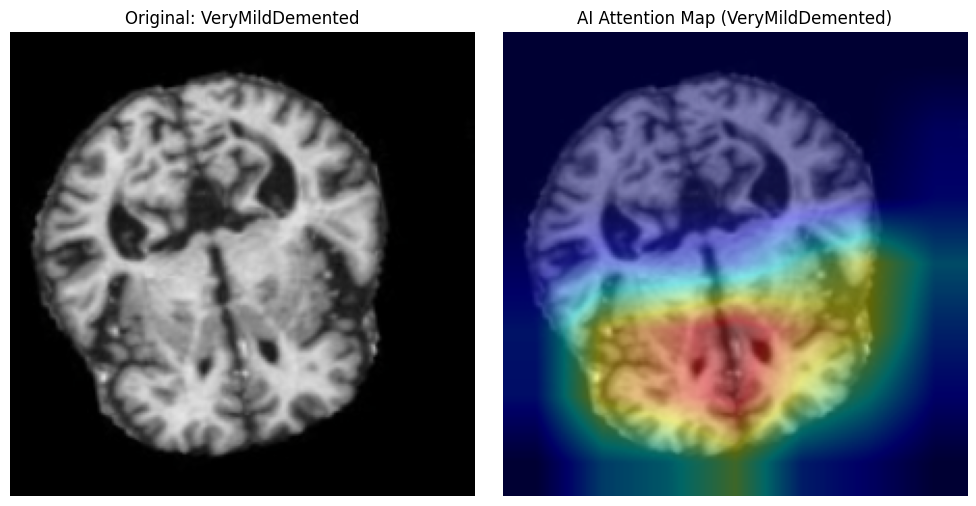

In [37]:
# Grad-CAM
import cv2


class GradCAM:
  def __init__(self, model, target_layer):
    self.model = model
    self.target_layer = target_layer
    self.gradients = None
    self.activations = None
    self.target_layer.register_forward_hook(self.save_activation)
    self.target_layer.register_full_backward_hook(self.save_gradient)

  def save_activation(self, module, input, output):
    self.activations = output

  def save_gradient(self, module, grad_input, grad_output):
    self.gradients = grad_output[0]

  def __call__(self, x, class_idx=None):
    # Forward Pass
    self.model.eval()
    output = self.model(x)

    if class_idx is None:
      class_idx = output.argmax(dim=1).item()

    # Backward Pass
    self.model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    # Heatmap
    # pool the gradients first
    pooled_gradients = torch.mean(self.gradients, dim=[0,2,3])

    # weight the activations by gradients
    activation = self.activations[0]
    for i in range(activation.shape[0]):
      activation[i, :, :] *= pooled_gradients[i]

      # average the channels to get a single 2d map
      heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()

      # cleanup
      # apply ReLU
      heatmap = np.maximum(heatmap, 0)
      if np.max(heatmap) !=0:
        heatmap /= np.max(heatmap)

    return heatmap, class_idx


def visualize_gradcam(model, dataset, index=None):
      # setup grad-cam on last layer of CNN
      grad_cam = GradCAM(model, model.cnn[-1])

      # get the image
      if index is None:
        index = np.random.randint(0, len(dataset))

        # get image and label from dataset
        # we are using the dataset object beacusing it handles and resises/transfomers, etc.
        img_tensor,label_idx = dataset[index]

        # Prepare image for model (adding the batch dimension)
        # The model expects [Batch, 3, 224, 224,] but we have [3, 224, 224]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        # generate heatmap
        heatmap, pred_idx = grad_cam(input_tensor)

        # visualization logic
        # resie the heatmapt to match orgina image size
        heatmap = cv2.resize(heatmap, (224, 224))

        # convert heatmap to rgb colors
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # prepare original image
        inv_normalize = transforms.Normalize(
            mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std = [1/0.229, 1/0.224, 1/0.225]
        )
        original_img = inv_normalize(img_tensor).permute(1,2,0).numpy()
        original_img = np.clip(original_img, 0, 1)
        original_img_uint8 = np.uint8(255 * original_img)
        original_img_uint8 =  cv2.cvtColor(original_img_uint8, cv2.COLOR_RGB2BGR)
        # overlay: 60% original image + 40% heatmap
        superimposed_img = cv2.addWeighted(original_img_uint8, 0.6, heatmap, 0.4, 0)

        # show it
        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.imshow(original_img)
        plt.title(f"Original: {le.classes_[label_idx]}")
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"AI Attention Map ({le.classes_[pred_idx]})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Run it!
print("Generating AI Attention Map...")
visualize_gradcam(model, test_ds)